In [1]:
#pip install textblob
import pandas as pd
from textblob import TextBlob
from sklearn import preprocessing

In [2]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = pd.read_csv("all-data.csv",encoding="Windows-1252")

In [4]:
data.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Rename columns

In [5]:
data = data.rename(columns={"neutral":"Sentiment", data.columns[1]:"text"})

In [6]:
data.head()

,Sentiment,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Below, we describe a function to lowercase text, remove punctuation and symbols from words, and other useless chars/words.

In [7]:
from bs4 import BeautifulSoup
import re
def text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    
    text = text.replace("(<br/>)", "")
    text = text.replace('(<a).*(>).*(</a>)', '')
    text = text.replace('(&amp)', '')
    text = text.replace('(&gt)', '')
    text = text.replace('(&lt)', '')
    text = text.replace('(\xa0)', ' ')
    
    text = text.lower()
    return text
data['text'] = data['text'].apply(text_cleaning)

Remove duplicates.

In [8]:
data.drop_duplicates(subset=['text'],keep='first',inplace=True)

Added 3 columns:
1) text sentiment polarity by TextBlob library

2) Lenght of each news text

3) Count of words in each news

In [9]:
data['polarity'] = data['text'].map(lambda text: TextBlob(text).sentiment.polarity)
data['news_len'] = data['text'].astype(str).apply(len)
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))

In [10]:
data.head()

,Sentiment,text,polarity,news_len,word_count
0,neutral,technopolis plans to develop in stages an area...,0.083333,190,31
1,negative,the international electronic industry company ...,0.000000,228,36
2,positive,with the new production plant the company woul...,-0.064802,206,33
3,positive,according to the company 's updated strategy f...,0.000000,203,41
4,positive,financing of aspocomp 's growth aspocomp is ag...,0.500000,178,25


Label Encoded data.Sentiment column into numeric type 

In [11]:
le = preprocessing.LabelEncoder()
arr = le.fit_transform(data.Sentiment)

In [12]:
data["Sentiment"] = arr

In [13]:
data.head()

,Sentiment,text,polarity,news_len,word_count
0,1,technopolis plans to develop in stages an area...,0.083333,190,31
1,0,the international electronic industry company ...,0.000000,228,36
2,2,with the new production plant the company woul...,-0.064802,206,33
3,2,according to the company 's updated strategy f...,0.000000,203,41
4,2,financing of aspocomp 's growth aspocomp is ag...,0.500000,178,25


Converted text into vectors by using TFidfVectorizer model and now data is ready.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(data['text'])

##Model Implementation 

In [15]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
from sklearn import utils
import keras
from gensim.models import Doc2Vec
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tqdm import tqdm

In [28]:
data.shape

(4837, 5)

In [20]:
data.index = range(4837)
data['text'].apply(lambda x: len(x.split(' '))).sum()

111725

In [21]:
data['text'] = data['text'].apply(text_cleaning)
train, test = train_test_split(data, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [22]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.Sentiment]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.Sentiment]), axis=1)

In [23]:
max_features = 500000
MAX_SEQ_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 4837 unique tokens.


In [25]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQ_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4837, 50)


In [26]:
train_tagged.values[1387]

TaggedDocument(words=['in', 'the', 'first', 'nine', 'months', 'of', '2010', ',', 'the', 'company', "'s", 'net', 'loss', 'narrowed', 'to', 'eur415', ',000', 'from', 'eur7', '.4', 'm', 'for', 'the', 'corresponding', 'period', 'of', '2009', '.'], tags=[2])

In [33]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 4836/4836 [00:00<00:00, 345901.33it/s]


In [34]:
for epoch in range(15):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4836/4836 [00:00<00:00, 1538972.24it/s]


In [35]:
print(d2v_model)
len(d2v_model.wv.vocab)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


11695

In [36]:
import numpy as np
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
          embedding_matrix[i]=vec

In [37]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)

[('loss', 0.8918544054031372),
 ('pharma', 0.8250756859779358),
 ('profits', 0.7726687788963318),
 ('income', 0.7623971700668335),
 ('prepares', 0.7469966411590576),
 ('break-even', 0.7272443771362305),
 ('result', 0.72614586353302),
 ('mistake', 0.7259354591369629),
 ('42.5', 0.7187619209289551),
 ('margin', 0.7043426036834717)]

In [38]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)

[('2-year', 0.7534468173980713),
 ('detailing', 0.7215679883956909),
 ('n.v.', 0.7198667526245117),
 ('rohwedder', 0.7198457717895508),
 ('property', 0.718389630317688),
 ('fleet', 0.7165646553039551),
 ('neomarkka', 0.7013294696807861),
 ('annual', 0.681770920753479),
 ('investor', 0.6785566210746765),
 ('wholly-owned', 0.6765480041503906)]

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


model = Sequential()
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            233920    
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 248,273
Trainable params: 248,273
Non-trainable params: 0
_________________________________________________________________


In [43]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4111, 50) (4111, 3)
(726, 50) (726, 3)


In [45]:
batch_size = 15
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
275/275 - 7s - loss: 0.0475 - acc: 0.9791 - 7s/epoch - 26ms/step
Epoch 2/50
275/275 - 8s - loss: 0.0515 - acc: 0.9769 - 8s/epoch - 31ms/step
Epoch 3/50
275/275 - 7s - loss: 0.0318 - acc: 0.9869 - 7s/epoch - 25ms/step
Epoch 4/50
275/275 - 8s - loss: 0.0250 - acc: 0.9910 - 8s/epoch - 31ms/step
Epoch 5/50
275/275 - 7s - loss: 0.0231 - acc: 0.9912 - 7s/epoch - 25ms/step
Epoch 6/50
275/275 - 8s - loss: 0.0245 - acc: 0.9905 - 8s/epoch - 31ms/step
Epoch 7/50
275/275 - 7s - loss: 0.0167 - acc: 0.9946 - 7s/epoch - 25ms/step
Epoch 8/50
275/275 - 11s - loss: 0.0147 - acc: 0.9939 - 11s/epoch - 39ms/step
Epoch 9/50
275/275 - 8s - loss: 0.0164 - acc: 0.9925 - 8s/epoch - 28ms/step
Epoch 10/50
275/275 - 8s - loss: 0.0188 - acc: 0.9922 - 8s/epoch - 28ms/step
Epoch 11/50
275/275 - 8s - loss: 0.0148 - acc: 0.9929 - 8s/epoch - 29ms/step
Epoch 12/50
275/275 - 7s - loss: 0.0095 - acc: 0.9964 - 7s/epoch - 27ms/step
Epoch 13/50
275/275 - 9s - loss: 0.0110 - acc: 0.9946 - 9s/epoch - 31ms/step
Epoch 

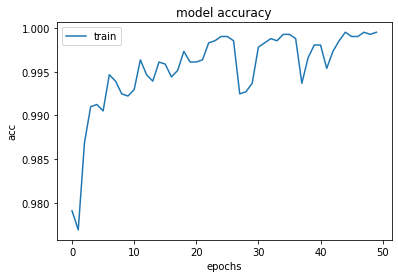

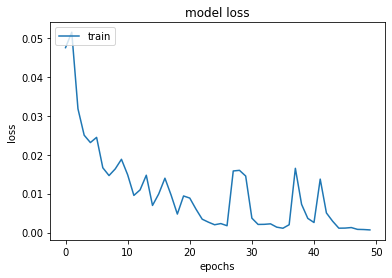

<Figure size 432x288 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [48]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 3s - loss: 5.7867e-04 - acc: 0.9995 - 3s/epoch - 24ms/step
23/23 - 1s - loss: 1.4243 - acc: 0.7080 - 579ms/epoch - 25ms/step
Train: 1.000, Test: 0.7080
